In [16]:
import torch
import pandas as pd
import numpy as np

# Import dataset utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import importlib
if importlib.util.find_spec('ipywidgets') is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm

In [17]:
dataframe = pd.read_csv('../data/final.csv', sep=';')
dataframe.head()

,sexo,Estado_civil,Status_empl,Licenca,Tipo_Resid,Residencia,Alcoolatra,Droga,Suic_familia,Dep_familia,...,Eixo I: Panico sem agorafobia,Eixo I: Fobia especifica,Eixo I: Fobia social,Eixo I: Obsessivo-compulsivo,Eixo I: Estresse pos-traumatico,Eixo I: Ansiedade generalizada,Eixo II: Personalidade paranoica,Eixo II: Transtorno de personalidade,TOC,idade
0,M,3.0,NaN,0.0,3.0,1.0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,40.0
1,F,1.0,3.0,0.0,4.0,3.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0
2,F,1.0,2.0,0.0,1.0,2.0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
3,F,1.0,3.0,0.0,1.0,3.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,30.0
4,F,4.0,2.0,0.0,1.0,NaN,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0


In [18]:
# replace all nans with -1
dataframe = dataframe.fillna(-1)

# drop Chave
dataframe = dataframe.drop(['Chave'], axis=1)

dataframe['sexo'].replace({'M': 0, 'F': 1}, inplace=True)


In [4]:
df_suic = dataframe.copy()

df_suic = df_suic.astype(float)

df_suic.shape



(3953, 68)

In [5]:
# turn -5 to -1
df_suic['Anos educacao formal'] = df_suic['Anos educacao formal'].replace(-5, -1)

In [6]:
# find min and max values for each column
min_max = {}
for col in df_suic.columns:
    min_max[col] = (df_suic[col].min(), df_suic[col].max())
# preety print
# for k, v in min_max.items():
#     print(f'{k}: {v}')

# Preety print unique values
for col in df_suic.columns:
    print(f'{col}: {df_suic[col].unique()}')
        

sexo: [ 0.  1. -1.]
Estado_civil: [ 3.  1.  4.  5.  2.  6. -1.]
Status_empl: [-1.  3.  2.  6.  4.  1.  5.]
Licenca: [ 0.  1. -1.]
Tipo_Resid: [ 3.  4.  1.  5.  2.  8. -1.  6.  7.]
Residencia: [ 1.  3.  2. -1.]
Alcoolatra: [0. 1.]
Droga: [0. 1.]
Suic_familia: [0. 1.]
Dep_familia: [1. 0.]
Bip_familia: [0. 1.]
Alc_familia: [1. 0.]
Drog_familia: [1. 0.]
coracao: [0. 1. 2. 3. 4.]
vascular: [0. 2. 1. 3.]
hematopoetico: [0. 1. 2. 4. 3.]
Olho_ore_nariz_garg_lar: [1. 0. 2. 3. 4.]
GI_sup: [1. 0. 2. 3. 4.]
Gi_inf: [0. 1. 2. 3. 4.]
Renal: [0. 1. 3. 2. 4.]
Genito_urinario: [0. 1. 2. 3. 4.]
Musculoesqueletico: [1. 0. 2. 4. 3.]
Neuro: [1. 0. 2. 3. 4.]
psiquiatrica: [1. 0. 3. 2. 4.]
Respiratorio: [2. 0. 1. 3. 4.]
Figado: [0. 1. 4. 2. 3.]
Endocrino_metabolico: [0. 2. 1. 3. 4.]
Anos educacao formal: [12. 18. 14. 10. 22. 17. 16. 15. 11. 21. 19.  9. 13.  2.  8.  7.  3. 20.
 23.  6. -1. 25.  0.  5.  4. 26. 27. 24.  1.]
Capaz de desfrutar das coisas: [ 2.  1.  3.  4. -1.  5.]
Impacto de sua familia e amigos

In [7]:
class MyDataset(Dataset):
 
  def __init__(self, input_dataframe, split="train", target=["Suicidio", "Ansiedade"], ignore_columns=[], train_ratio=0.8):
    
    self.split = split
    self.target = target
    self.ignore_columns = ignore_columns

    for coll in self.ignore_columns:
       if coll in input_dataframe.columns:
        input_dataframe = input_dataframe.drop(coll, axis=1)

    # self.classification_dim = len(input_dataframe[self.target].unique())
    self.data_dim = len(input_dataframe.columns) - len(target) - len(ignore_columns)
    self.embbeding_dim = input_dataframe.max().max() + 1

    y = input_dataframe[target].values
    x = input_dataframe.drop(target, axis = 1).values

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=42)

  def __len__(self):
    if self.split == "train":
      return len(self.x_train)
    elif self.split == "test":
      return len(self.x_test)
    else:
      raise ValueError("Split must be train or test")

  def get_weights(self):
    if self.split == "train":
      y = self.y_train
    elif self.split == "test":
      y = self.y_test

    weights = []
    for i in range(len(self.target)):
      weights_dict = pd.DataFrame(y[:,i]).value_counts(normalize=True).to_dict()
      keys = sorted([k for k in weights_dict.keys()], key=lambda x: x[0])
      weights.append(np.array([1/weights_dict[k] for k in keys]))
    self.weights = np.hstack(weights).T

    return self.weights

  def __getitem__(self,idx):
    # target = torch.zeros(self.classification_dim)

    if self.split == "train":
      # target[self.y_train[idx]] = 1
      target = torch.tensor(self.y_train[idx], dtype=torch.float)
      return (torch.tensor(self.x_train[idx], dtype=torch.float), target)
    elif self.split == "test":
      # target[self.y_test[idx]] = 1
      target = torch.tensor(self.y_test[idx], dtype=torch.float)
      return (torch.tensor(self.x_test[idx], dtype=torch.float), target)
    else:
      raise ValueError("Split must be train or test")

In [8]:
# Make embbeding layer with one different embbeding for each column and acount for the -1 values
class MyEmbbeding(nn.Module):
    def __init__(self, dataframe, fake=False):
        super(MyEmbbeding, self).__init__()
        self.embbedings = nn.ModuleList()
        self.fake = fake
        # create embbeding for each column in order
        for col in dataframe.columns:
            self.embbedings.append(nn.Embedding(int(dataframe[col].max()+10), 1))


    def forward(self, x):
        if self.fake:
            return x

        embbedings = []
        assert x.shape[1] == len(self.embbedings), f"Input shape {x.shape} must be equal to number of embbedings {len(self.embbedings)}"
        for i, embbeding in enumerate(self.embbedings):
            # print embbeding max label
            embbedings.append(embbeding(x[:,i].long()+1))
        return torch.cat(embbedings, dim=1)

In [9]:
# Create classification model using the embbeding layer and output a one hot vector with the classification
class NNModel(nn.Module):
    def __init__(self, embbeding, hidden_dim=64, output_dim=1):
        super(NNModel, self).__init__()
        self.embbeding = embbeding
        self.fc1 = nn.Linear(embbeding.embbedings[0].embedding_dim*len(embbeding.embbedings), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    # regressive output
    def forward(self, x):
        x = self.embbeding(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training 

In [10]:
test_dataset = MyDataset(df_suic, "test", target=[])
train_dataset = MyDataset(df_suic, "train", target=[])

full_dataset = MyDataset(df_suic, "train", target=[], train_ratio=0.99)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

full_dataloader = DataLoader(full_dataset, batch_size=256, shuffle=True)

In [11]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3162
Test dataset size: 791


In [12]:
# make train loop on cpu to reconstruct the model
embbeding = MyEmbbeding(df_suic, fake=False)

model = NNModel(embbeding, output_dim=len(df_suic.columns))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
eary_stopping = 0.01

epochs = 1000
for epoch in range(epochs):
    print(f"Epoch {epoch}")

    # if epoch > 10:
    #     optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    mean_loss = 0
    acc = []
    for i, batch in enumerate(full_dataloader):
        x, _ = batch
        y = x
        res = model(x)

        # compute loss and backprop using scheduler
        loss = criterion(res, y)
        loss.backward()
        # scheduler.step(loss)
        optimizer.step()
        optimizer.zero_grad()

        # compute accuracy for each dimension
        acc.append([(res[:,i].round() == y[:,i]).sum().item()/len(y) for i in range(y.shape[1])] )

        mean_loss += loss
    mean_loss /= len(full_dataloader)
    acc = np.mean(acc, axis=0)

    print(f"[{epoch}]Train loss {mean_loss}, acc {acc.mean()}")

    # stop at overfitting
    if mean_loss < eary_stopping:
        break

    with torch.no_grad():
        mean_loss = 0
        acc = []
        for i, batch in enumerate(test_dataloader):
            x, _ = batch
            y = x

            res = model(x)

            # compute loss and backprop using scheduler
            loss = criterion(res, y)

            # compute accuracy for each dimension
            acc.append([(res[:,i].round() == y[:,i]).sum().item()/len(y) for i in range(y.shape[1])] )

            mean_loss += loss
        mean_loss /= len(test_dataloader)
        acc = np.mean(acc, axis=0)

        print(f"[{epoch}]Test loss {mean_loss}, acc {acc.mean()}")


Epoch 0
[0]Train loss 128248.21875, acc 0.4768188378198025
[0]Test loss 108276.7421875, acc 0.4721427429667519
Epoch 1
[1]Train loss 126383.2421875, acc 0.4768188378198025
[1]Test loss 108865.3203125, acc 0.47203484654731453
Epoch 2
[2]Train loss 146021.859375, acc 0.47699884480761484
[2]Test loss 107486.8828125, acc 0.4721427429667519
Epoch 3
[3]Train loss 126036.40625, acc 0.47631481825392835
[3]Test loss 108022.09375, acc 0.4721427429667519
Epoch 4
[4]Train loss 130106.765625, acc 0.47694484271127113
[4]Test loss 108189.0, acc 0.47189098465473145
Epoch 5
[5]Train loss 130200.359375, acc 0.4763868210490532
[5]Test loss 107554.2265625, acc 0.47245923913043475
Epoch 6
[6]Train loss 132071.734375, acc 0.4762068140612409
[6]Test loss 108800.5234375, acc 0.4720132672634271
Epoch 7
[7]Train loss 126051.046875, acc 0.47649482524174047
[7]Test loss 110638.5234375, acc 0.4719916879795396
Epoch 8
[8]Train loss 127008.3828125, acc 0.476530826639303
[8]Test loss 107291.2734375, acc 0.47212116368

In [33]:
# save model
torch.save(model.state_dict(), "model.pth")

# save embbeding
torch.save(embbeding.state_dict(), "embbeding.pth")

In [19]:
# use trained embbeding to transform train and test data

new_data = []
for batch in train_dataloader:
    x, y = batch
    transformed = embbeding(x)

    new_data.append(transformed.detach().numpy())

new_data = np.concatenate(new_data, axis=0)

# put new data in dataframe with same columns as original data
new_df = pd.DataFrame(new_data, columns=df_suic.columns)

# save new data
new_df.to_csv("new_data.csv", index=False)


# Graph Discovery

In [1]:
import causalnex.structure.notears as notears
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [30]:
df = pd.read_csv("gcn_checkpoints/new_data.csv")

# sample 10% of the data
# df = df.sample(frac=0.1)

# sample 10 columns
# df = df.sample(n=10, axis=1)

# selected = ['Suicidio','sexo', 'Estado_civil', 'Tipo_Resid','idade',
#                    'Alcoolatra', 'Droga', 'Suic_familia', 'Dep_familia',
#                    'Alc_familia', 'Drog_familia',
#                    'Neuro',
#                    'psiquiatrica', 'Anos educacao formal', 'Capaz de desfrutar das coisas',
#                    'Impacto de sua familia e amigos',
#                    'Capaz de tomar decisões importantes', 'Estudante',
#                    'Insonia',
#                    'Deprimido', 'Ansiedade',
#                    'Perda de insights', 'Apetite', 'Perda de peso', 'Ansiedade somática',
#                    'Hipocondriase', 'Sentimentos_culpa', 
#                    'Trabalho e interesses', 'Energia', 'Lentidao pensamento e fala',
#                    'Agitação', 'Libido', 'TOC']

# df = df[selected]

In [ ]:
sm = notears.from_pandas(df, max_iter=1000, tabu_edges=[], tabu_parent_nodes=[], tabu_child_nodes=[])


ths = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
for i, ax in enumerate(axs.flatten()):
    if i > len(ths) - 1:
        # Clean up empty axes
        fig.delaxes(ax)
        continue

    th = ths[i]
    sm.remove_edges_below_threshold(th)

    # Draw only nodes with edges
    sm2 = sm.edge_subgraph(sm.edges)
    labels = {node: node for node in sm2.nodes}
    nx.draw(sm, ax=ax, with_labels=True, nodelist=sm2.nodes, labels=labels, node_size=100, font_size=10)

    # Add rec around ax to make it easier to see
    axis = ax.axis()
    rec = plt.Rectangle((axis[0], axis[2]), (axis[1] - axis[0]), (axis[3] - axis[2]), fill=False, lw=4, linestyle="dotted")
    ax.add_patch(rec)
    ax.set_title(f"Threshold: {th}")



fig.show()

In [47]:
# Load csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

W_graph = np.loadtxt("../W_est.csv", delimiter=",")

In [44]:
# creat directed graph
G = nx.from_numpy_matrix(W_graph, create_using=nx.DiGraph)

# add labels from df to the graph
labels = {i: df.columns[i] for i in range(len(df.columns))}
G = nx.relabel_nodes(G, labels)

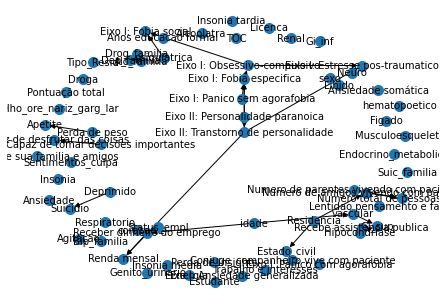

In [45]:
# draw graph usinf df columns as labels
nx.draw(G, with_labels=True, node_size=100, font_size=10)

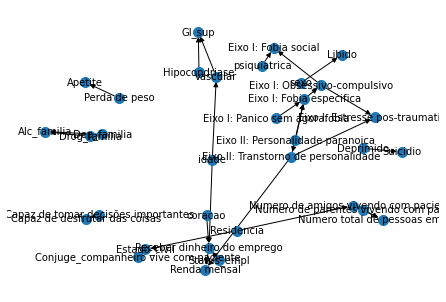

In [46]:
# remove nodes with no edges
G2 = G.edge_subgraph(G.edges)
nx.draw_spring(G2, with_labels=True, node_size=100, font_size=10)

sexo -> Libido : 0.40480943246910356


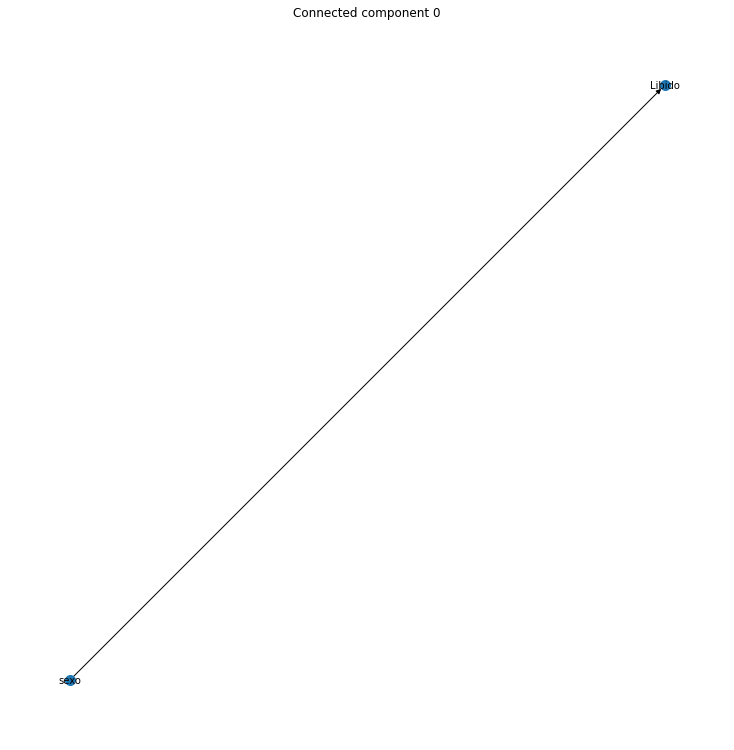

Capaz de tomar decisões importantes -> Capaz de desfrutar das coisas : 2.7597227255076437


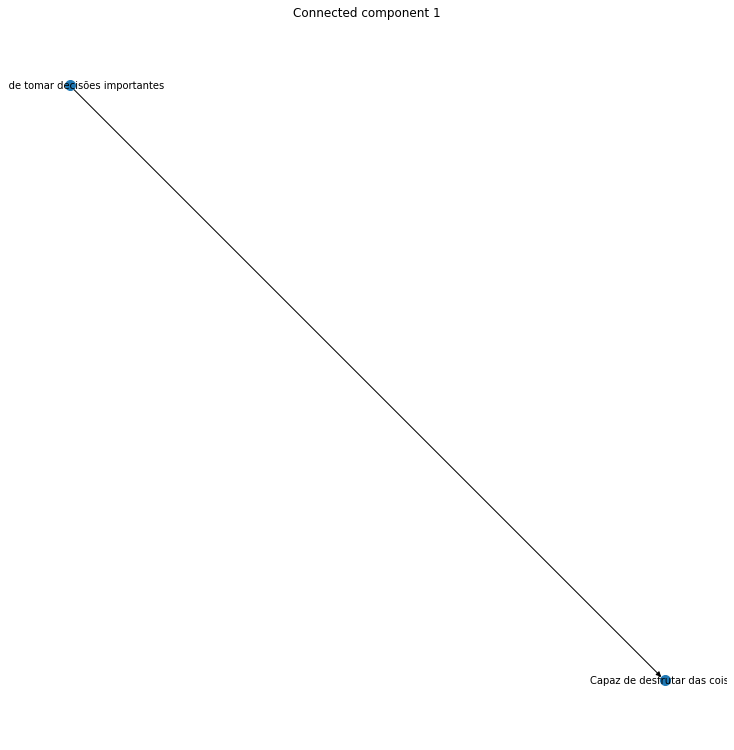

Numero de amigos vivendo com paciente -> Numero total de pessoas em casa : 1.3232654233162389
Numero de parentes vivendo com paciente -> Numero total de pessoas em casa : 3.3066929233262052
Residencia -> Estado_civil : 0.5437600211738094
Residencia -> Numero de amigos vivendo com paciente : 0.33556559663191227
Estado_civil -> Conjuge_companheiro vive com paciente : 3.1072571252424677


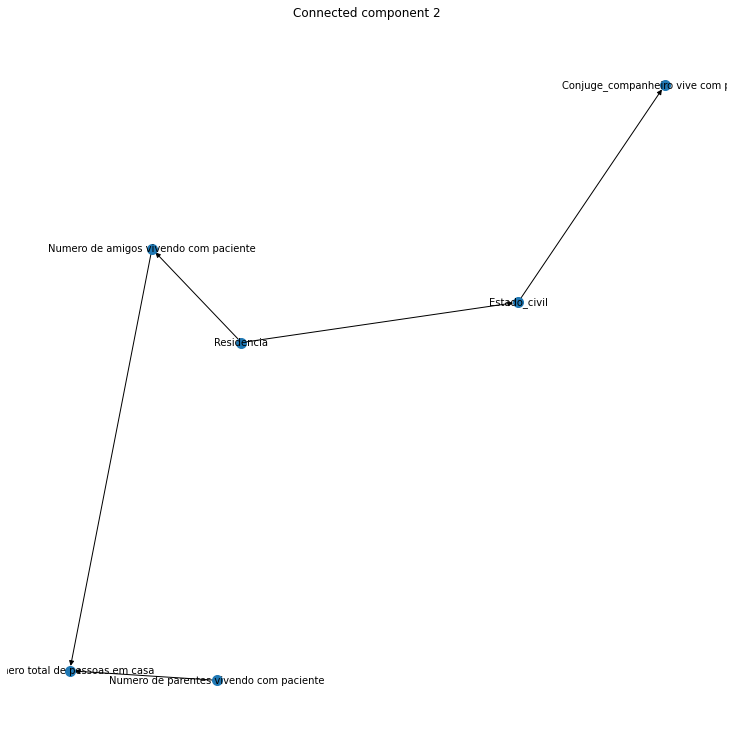

Eixo II: Personalidade paranoica -> Eixo I: Fobia especifica : 0.324758449075101
Eixo II: Personalidade paranoica -> Eixo II: Transtorno de personalidade : 2.0200765709840622
Eixo I: Obsessivo-compulsivo -> Eixo I: Fobia social : 0.4728779369705947
Eixo I: Obsessivo-compulsivo -> Eixo I: Estresse pos-traumatico : 0.46985029512814486
Status_empl -> Receber dinheiro do emprego : 0.3906613137716857
Eixo I: Panico sem agorafobia -> Eixo I: Fobia especifica : 0.44186757229848145
psiquiatrica -> Eixo I: Fobia social : 0.4916820304109536
idade -> vascular : 0.4144072408820964
idade -> Receber dinheiro do emprego : 0.36316079803247603
vascular -> GI_sup : 0.30372591379979463
Hipocondriase -> GI_sup : 0.3123171304239165
Eixo I: Fobia especifica -> Eixo I: Obsessivo-compulsivo : 2.6640211082771734
Eixo II: Transtorno de personalidade -> Renda mensal : 0.35147311046076973
Eixo II: Transtorno de personalidade -> Eixo I: Fobia especifica : 1.095843461214112
Eixo II: Transtorno de personalidade -> E

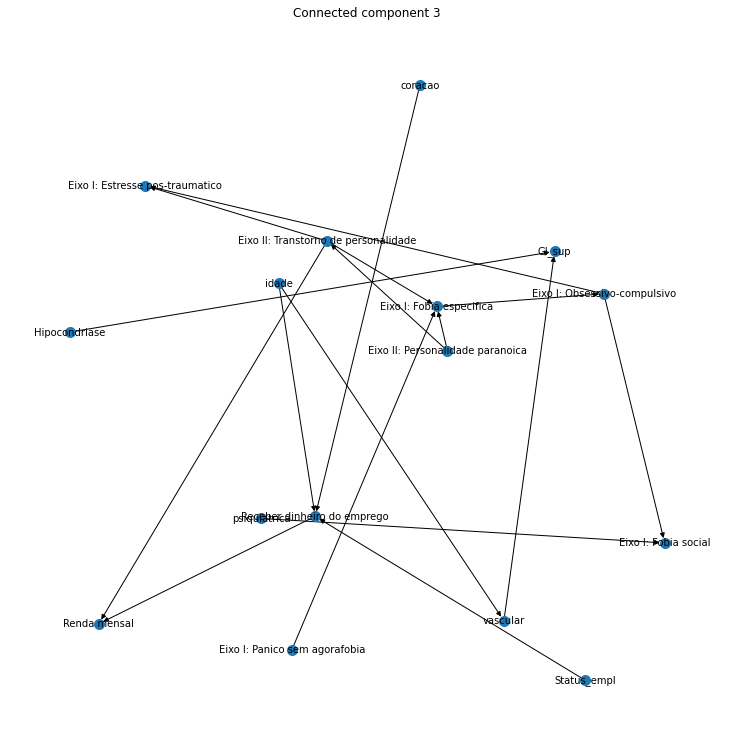

Perda de peso -> Apetite : 0.7684563668465694


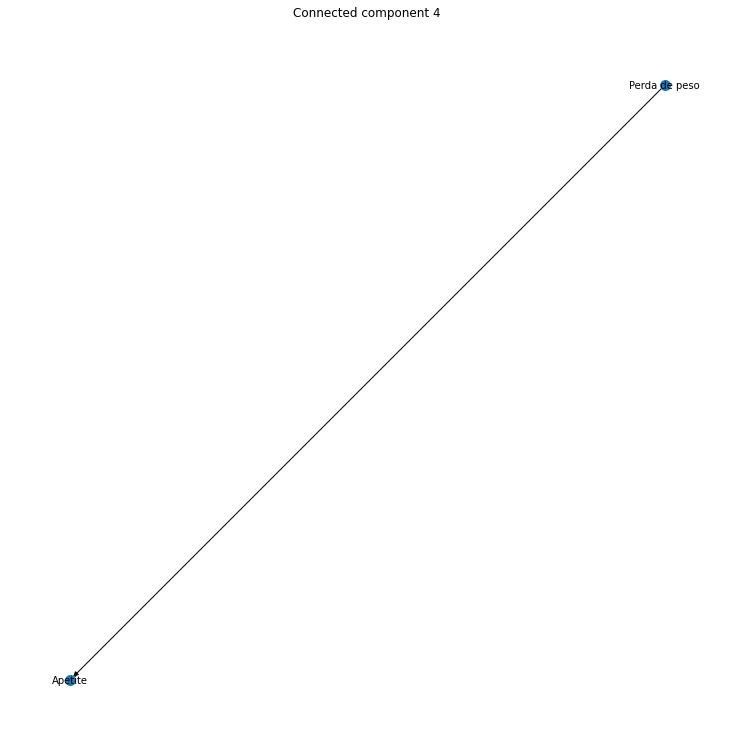

Drog_familia -> Alc_familia : 0.8888747225272005
Dep_familia -> Alc_familia : 0.305903092393961
Dep_familia -> Drog_familia : 0.4194728895828897


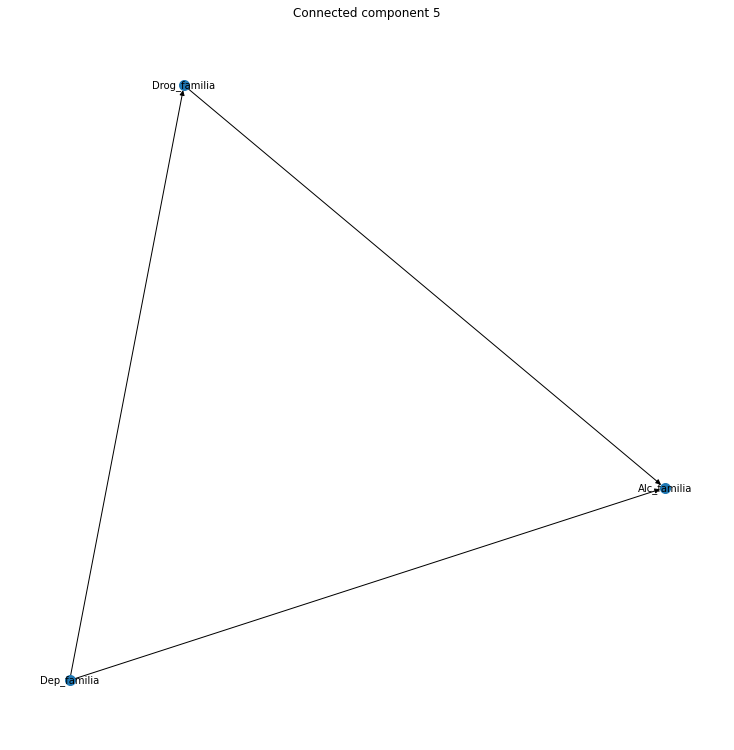

Deprimido -> Suicidio : 0.42533323431720943


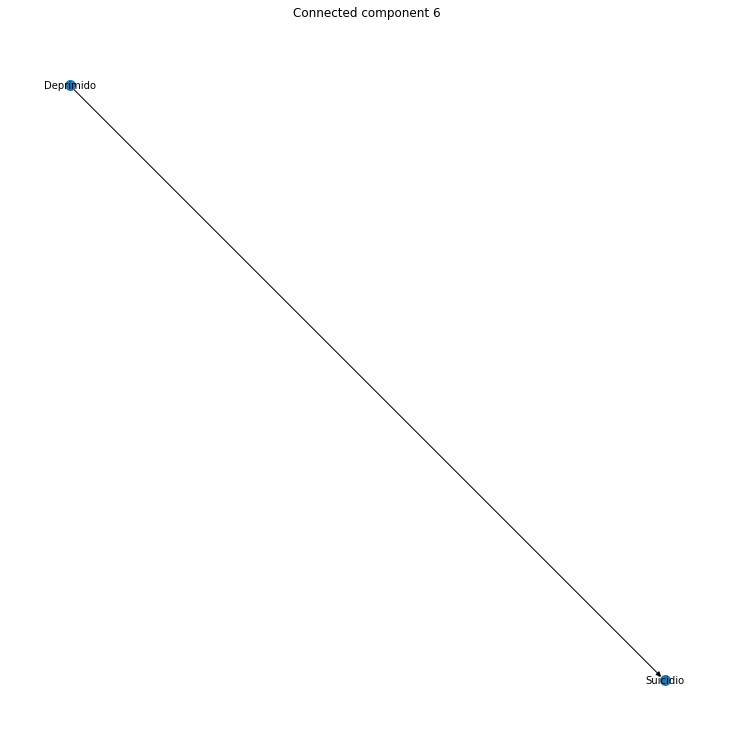

In [34]:
# draw connected components separately with each fig of size (20, 20) without subplots
# get G2 as undirected graph
un_G2 = G2.to_undirected()
for i, g in enumerate(nx.connected_components(un_G2)):
    plt.figure(figsize=(10, 10))
    sub_g = G2.subgraph(g)
    # turn ti directed graph
    # add padding to make sure all nodes are visible
    pos = nx.spring_layout(sub_g, k=0.5, iterations=20)
    nx.draw(sub_g, pos=pos, with_labels=True, node_size=100, font_size=10)

    # get node names and weights
    edges = sub_g.edges
    weights = [sub_g[u][v]['weight'] for u, v in edges]
    for (u, v), w in zip(edges, weights):
        print(f"{u} -> {v} : {w}")

    plt.title(f"Connected component {i}")
    plt.show()

In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, Notears

# data simulation, simulate true causal dag and train_data.
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=10, 
                                      weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='linear', 
                        sem_type='gauss')
true_causal_matrix, X = dataset.B, dataset.X

# structure learning
pc = Notears()
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [31]:
nt = Notears()
nt.learn(df.values)

2022-12-10 17:06:34,068 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=3162, d=68, iter_=100, h_=1e-08, rho_=1e+16
2022-12-10 17:06:34,342 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=4.131e-01, loss=33.732, rho=1.0e+00
2022-12-10 17:06:34,571 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=2.989e-01, loss=28.500, rho=1.0e+00
2022-12-10 17:06:34,971 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=1.420e-01, loss=29.268, rho=1.0e+01
2022-12-10 17:06:35,354 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=4.520e-02, loss=36.948, rho=1.0e+02
2022-12-10 17:06:

In [36]:
W = nt.causal_matrix

Signature: Notears.learn(self, data, columns=None, **kwargs)
Docstring:
Set up and run the Notears algorithm.

Parameters
----------
data: castle.Tensor or numpy.ndarray
    The castle.Tensor or numpy.ndarray format data you want to learn.
columns : Index or array-like
    Column labels to use for resulting tensor. Will default to
    RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
File:      /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/algorithms/gradient/notears/linear.py
Type:      function
